<a href="https://colab.research.google.com/github/JaffeMarques/fakeNewsDetector/blob/master/fakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detector
## Project Overview
This project implements a machine learning model to detect fake news articles using natural language processing techniques. It's implemented as a Jupyter Notebook and utilizes various Python libraries for data processing, model training, and visualization.


# Setting up environment


In [1]:
!pip install gitpython
!pip install Unidecode

In [2]:
import nltk
import git
import os
import pandas as pd
import numpy as np
import csv
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.utils import resample
from sklearn.preprocessing import FunctionTransformer
from unidecode import unidecode
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.path import Path
from matplotlib.patches import PathPatch

from nltk.corpus import mac_morpho
nltk.download('mac_morpho')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')


[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
sentencas_treinamento = mac_morpho.tagged_sents()
tagger = nltk.UnigramTagger(sentencas_treinamento)

# Data Preparation
Downloading files and assembling data. This step should only be executed if you don't have the normalized file in the temp folder.

In [4]:
local_path = 'temp'
if not os.path.exists(local_path):
  url_repo = 'https://github.com/roneysco/Fake.br-Corpus'
  clone = git.Repo.clone_from(url_repo, local_path)

fake_meta_path = 'full_texts/fake-meta-information'
true_meta_path = 'full_texts/true-meta-information'
true_normalized_path = 'size_normalized_texts/true'
fake_normalized_path = 'size_normalized_texts/fake'

linhas_fake = []
linhas_tmp_fake = []

linhas_true = []
linhas_tmp_true = []

list_dir_fake = os.listdir(os.path.join(local_path, fake_meta_path))
list_dir_fake.sort(key = lambda x: int(x.split('-')[0]))
list_dir_fake_tmp = os.listdir(os.path.join(local_path, fake_normalized_path))
list_dir_fake_tmp.sort()


list_dir_true = os.listdir(os.path.join(local_path, true_meta_path))
list_dir_true.sort(key = lambda x: int(x.split('-')[0]))
list_dir_true_tmp = os.listdir(os.path.join(local_path, true_normalized_path))
list_dir_true_tmp.sort()

In [5]:
# Fake
for file_name in list_dir_fake:
  with open(os.path.join(local_path + '/' + fake_meta_path, file_name), 'r') as arquivo:
    data = [line.strip() for line in arquivo]
    linhas_fake.append([{
        'full_text_normalized': '',
        'link': data[1],
        'category': data[2],
        'number_of_links': data[6],
        'number_of_verbs': data[9],
        'number_of_si_verbs': data[10],
        'number_of_nouns': data[11],
        'number_of_adjectives': data[12],
        'number_of_adverbs': data[13],
        'number_of_modal_verbs': data[14],
        'number_of_si_pronouns': data[15],
        'number_of_plural_pronouns': data[16],
        'number_of_pronouns': data[17],
        'pausality': data[18],
        'date_of_publication': data[3],
        'file_name': file_name,
        'fake': 1
    }])

for file_name in list_dir_fake_tmp:
  with open(os.path.join(local_path + '/' + fake_normalized_path, file_name), 'r') as arquivo:
    linhas_tmp_fake.append(arquivo.read())

for i in range(len(linhas_tmp_fake)):
  linhas_fake[i][0]['full_text_normalized'] = linhas_tmp_fake[i]


# Verdadeiros
for file_name in list_dir_true:
  with open(os.path.join(local_path + '/' + true_meta_path, file_name), 'r') as arquivo:
    data = [line.strip() for line in arquivo]
    linhas_true.append([{
        'full_text_normalized': '',
        'link': data[1],
        'category': data[2],
        'number_of_links': data[6],
        'number_of_verbs': data[9],
        'number_of_si_verbs': data[10],
        'number_of_nouns': data[11],
        'number_of_adjectives': data[12],
        'number_of_adverbs': data[13],
        'number_of_modal_verbs': data[14],
        'number_of_si_pronouns': data[15],
        'number_of_plural_pronouns': data[16],
        'number_of_pronouns': data[17],
        'pausality': data[18],
        'date_of_publication': data[3],
        'file_name': file_name,
        'fake': 0
    }])

for file_name in list_dir_true_tmp:
  with open(os.path.join(local_path + '/' + true_normalized_path, file_name), 'r') as arquivo:
    linhas_tmp_true.append(arquivo.read())

for i in range(len(linhas_tmp_true)):
  linhas_true[i][0]['full_text_normalized'] = linhas_tmp_true[i]

In [6]:
linhas_geral = linhas_fake + linhas_true
colunas = list(linhas_geral[0][0].keys())

dados = []
for linha in linhas_geral:
    for d in linha:
        dados.append(list(d.values()))

df = pd.DataFrame(dados, columns=colunas)
display(df)

,full_text_normalized,link,category,number_of_links,number_of_verbs,number_of_si_verbs,number_of_nouns,number_of_adjectives,number_of_adverbs,number_of_modal_verbs,number_of_si_pronouns,number_of_plural_pronouns,number_of_pronouns,pausality,date_of_publication,file_name,fake
0,Kátia Abreu diz que vai colocar sua expulsão e...,https://ceticismopolitico.com/2017/11/30/katia...,politica,120,30,1,46,7,13,5,2,0,26,2.0,2017-11-30,1-meta.txt,1
1,"Dr. Ray peita Bolsonaro, chama-o de “conservad...",https://ceticismopolitico.com/2017/11/28/blog-...,sociedade_cotidiano,187,62,1,75,13,25,7,0,0,30,3.29412,2017-11-28,2-meta.txt,1
2,Reinaldo Azevedo desmascarado pela Polícia Fed...,https://ceticismopolitico.com/2017/11/28/alckm...,politica,150,39,3,64,9,18,5,1,0,14,3.57143,2017-11-28,3-meta.txt,1
3,Relatório assustador do BNDES mostra dinheiro ...,https://ceticismopolitico.com/2017/11/28/cara-...,politica,185,42,0,84,12,11,5,0,0,23,2.33333,2017-11-28,4-meta.txt,1
4,"Radialista americano fala sobre o PT: ""Eles ve...",https://ceticismopolitico.com/2017/11/27/temer...,politica,96,20,0,36,9,8,1,0,0,12,2.63636,2017-11-27,5-meta.txt,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,"Para jornal britânico, ação contra Lula na Lav...",https://g1.globo.com/politica/noticia/como-a-b...,politica,720,195,4,476,128,38,21,0,0,77,3.53731,21/01/2018 09h41,3598-meta.txt,0
7196,Temer diz que acionou PF e Cade para investiga...,https://g1.globo.com/pr/parana/noticia/alvo-da...,politica,507,187,0,352,36,49,28,0,0,42,2.96774,27/07/2017 10h49,3599-meta.txt,0
7197,Os obstáculos políticos de Temer em 2017. Espe...,https://g1.globo.com/pa/para/noticia/chefs-con...,sociedade_cotidiano,431,141,3,252,52,55,18,1,4,70,3.31707,10/11/2017 22h41,3600-meta.txt,0
7198,"Sexta-feira, 15 de setembro de 2017. Boa noite...",http://politica.estadao.com.br/blogs/neumanne/...,tv_celebridades,684,197,13,360,88,69,24,0,0,104,3.11538,24 de julho de 2017,3601-meta.txt,0


In [7]:
stop_words = set(stopwords.words('portuguese'))
stop_words_manual = ['ter',
                     'apos',
                     'caso',
                     'dia',
                     'segunda feira',
                     'terca feira',
                     'quarta feira',
                     'quinta feira',
                     'sexta feira']

stop_words.update(stop_words_manual)
df_stop_words = df
df_stop_words['full_text_normalized'] = df['full_text_normalized'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
display(df)

,full_text_normalized,link,category,number_of_links,number_of_verbs,number_of_si_verbs,number_of_nouns,number_of_adjectives,number_of_adverbs,number_of_modal_verbs,number_of_si_pronouns,number_of_plural_pronouns,number_of_pronouns,pausality,date_of_publication,file_name,fake
0,"Kátia Abreu diz vai colocar expulsão moldura, ...",https://ceticismopolitico.com/2017/11/30/katia...,politica,120,30,1,46,7,13,5,2,0,26,2.0,2017-11-30,1-meta.txt,1
1,"Dr. Ray peita Bolsonaro, chama-o “conservador ...",https://ceticismopolitico.com/2017/11/28/blog-...,sociedade_cotidiano,187,62,1,75,13,25,7,0,0,30,3.29412,2017-11-28,2-meta.txt,1
2,Reinaldo Azevedo desmascarado Polícia Federal....,https://ceticismopolitico.com/2017/11/28/alckm...,politica,150,39,3,64,9,18,5,1,0,14,3.57143,2017-11-28,3-meta.txt,1
3,Relatório assustador BNDES mostra dinheiro púb...,https://ceticismopolitico.com/2017/11/28/cara-...,politica,185,42,0,84,12,11,5,0,0,23,2.33333,2017-11-28,4-meta.txt,1
4,"Radialista americano fala sobre PT: ""Eles vend...",https://ceticismopolitico.com/2017/11/27/temer...,politica,96,20,0,36,9,8,1,0,0,12,2.63636,2017-11-27,5-meta.txt,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,"jornal britânico, ação contra Lula Lava Jato j...",https://g1.globo.com/politica/noticia/como-a-b...,politica,720,195,4,476,128,38,21,0,0,77,3.53731,21/01/2018 09h41,3598-meta.txt,0
7196,Temer diz acionou PF Cade investigar aumentos ...,https://g1.globo.com/pr/parana/noticia/alvo-da...,politica,507,187,0,352,36,49,28,0,0,42,2.96774,27/07/2017 10h49,3599-meta.txt,0
7197,obstáculos políticos Temer 2017. Especialistas...,https://g1.globo.com/pa/para/noticia/chefs-con...,sociedade_cotidiano,431,141,3,252,52,55,18,1,4,70,3.31707,10/11/2017 22h41,3600-meta.txt,0
7198,"Sexta-feira, 15 setembro 2017. Boa noite! Aqui...",http://politica.estadao.com.br/blogs/neumanne/...,tv_celebridades,684,197,13,360,88,69,24,0,0,104,3.11538,24 de julho de 2017,3601-meta.txt,0


# Data Cleaning

Removing words with low semantic meaning.

In [8]:
def preprocess_text(texto):
    texto_sem_acentos = unidecode(texto)
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    texto = texto.lower()
    return texto_sem_acentos

df['full_text_normalized'] = df['full_text_normalized'].apply(preprocess_text)

# Training the Model
In this stage, we prepare, split, and train the data.

In [9]:
fake_data = df[df['fake'] == 1]
true_data = df[df['fake'] == 0]

# Amostragem dos dados falsos para balanceamento
fake_data_sampled = resample(fake_data, n_samples=len(true_data), random_state=42)
dados_balanceados = pd.concat([fake_data_sampled, true_data])

# Divisão em recursos e rótulos
recursos =  dados_balanceados[['full_text_normalized',
                           'category',
                          'number_of_links',
                          'number_of_verbs',
                          'number_of_si_verbs',
                          'number_of_nouns',
                          'number_of_adjectives',
                          'number_of_adverbs',
                          'number_of_modal_verbs',
                          'number_of_si_pronouns',
                          'number_of_plural_pronouns',
                          'number_of_pronouns',
                          'pausality',
                          'date_of_publication']]

rotulos = dados_balanceados['fake']

recursos_treinamento, recursos_teste, rotulos_treinamento, rotulos_teste = train_test_split(recursos, rotulos, test_size=0.3, random_state=42)

stop_words = stopwords.words('portuguese')

recursos_treinamento_preprocessados = [preprocess_text(text) for text in recursos_treinamento['full_text_normalized']]
recursos_teste_preprocessados = [preprocess_text(text) for text in recursos_teste['full_text_normalized']]

vetorizador = TfidfVectorizer(stop_words=stop_words)
recursos_treinamento_vetorizados = vetorizador.fit_transform(recursos_treinamento_preprocessados)
recursos_teste_vetorizados = vetorizador.transform(recursos_teste_preprocessados)

modelo = LogisticRegression()
modelo.fit(recursos_treinamento_vetorizados, rotulos_treinamento)

previsoes = modelo.predict(recursos_teste_vetorizados)
precisao = accuracy_score(rotulos_teste, previsoes)
porcentagem = round(precisao * 100, 2)
print("Precisão do modelo: "+ str(porcentagem) +"% RU: 3729620")

Precisão do modelo: 91.3% RU: 3729620


# Generating Word Cloud

Words Marked as True

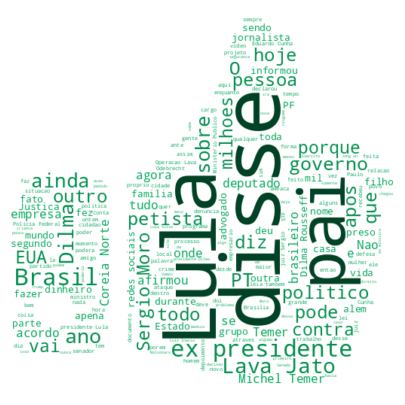

In [14]:
fake_1_data_stop = df_stop_words[df_stop_words['fake'] == 1]
todas_palavras = ' '.join(fake_1_data_stop['full_text_normalized'])

like_image = Image.open('/content/drive/MyDrive/img_fake/like.png')
like_image_rgba = like_image.convert('RGBA')

mask = np.array(like_image_rgba)
wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask)

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    palette = ['#00A858', '#008F4C', '#00773F', '#005E32', '#004225']
    index = min(int(font_size / 20), len(palette) - 1)
    return palette[index]

wordcloud = wordcloud.generate(todas_palavras)
wordcloud = wordcloud.recolor(color_func=green_color_func)

image_colors = ImageColorGenerator(mask)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

text = ""
text_x = -wordcloud.mask.shape[1] / 2 + 235
text_y = wordcloud.mask.shape[0] / 2 + 70
plt.text(text_x, text_y, text, fontsize=14, ha='left', va='center', rotation='vertical', color='#004225')

plt.show()

Words Marked as False

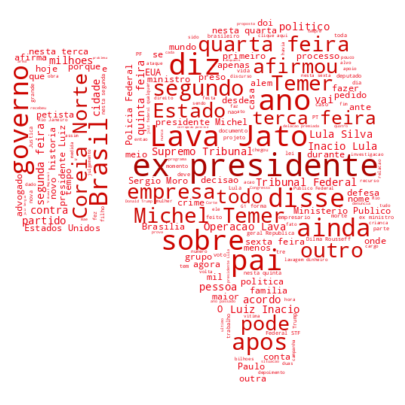

In [13]:
fake_0_data_stop = df_stop_words[df_stop_words['fake'] == 0]
todas_palavras = ' '.join(fake_0_data_stop['full_text_normalized'])

like_image = Image.open('/content/drive/MyDrive/img_fake/deslike.png')
like_image_rgba = like_image.convert('RGBA')

mask = np.array(like_image_rgba)
wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask)

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    palette = ['#EB0011', '#CD0500', '#AB0400', '#870300', '#600000']
    index = min(int(font_size / 20), len(palette) - 1)
    return palette[index]

wordcloud = wordcloud.generate(todas_palavras)
wordcloud = wordcloud.recolor(color_func=red_color_func)

image_colors = ImageColorGenerator(mask)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

text = ""
text_x = -wordcloud.mask.shape[1] / 2 + 235
text_y = wordcloud.mask.shape[0] / 2 - 90
plt.text(text_x, text_y, text, fontsize=14, ha='left', va='center', rotation='vertical', color='#600000')

plt.show()